In [3]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import uproot
import h5py
import os

Welcome to JupyROOT 6.24/00


In [3]:
templatefile = ROOT.TFile.Open('templates/AD_Templates.root',"READ")
muonfile = ROOT.TFile.Open('AD1_Wet_MuonTracking.root', "READ")

Warning in <TClass::Init>: no dictionary for class TCumulativeMap<string,double> is available
Warning in <TClass::Init>: no dictionary for class TCumulative is available
Warning in <TClass::Init>: no dictionary for class CumulativeData is available


In [4]:
graph_early = templatefile.Get("gPSD_Template_0_0")
#graph_late = templatefile.Get("gPSD_Template_0_1")
PSDvE = muonfile.Get("MuonTracking/hPSDvE")

In [5]:
def get_xy_from_TGraph(graph): 
    
    n = graph.GetN()
    
    x = np.asarray([])
    y = np.asarray([])

    for i in range(n): 
        x = np.append(x, graph.GetPointX(i))
        y = np.append(y, graph.GetPointY(i))
        
    return x, y


In [5]:
x,y = get_xy_from_TGraph(graph_early)
half_max = np.amax(y)/2

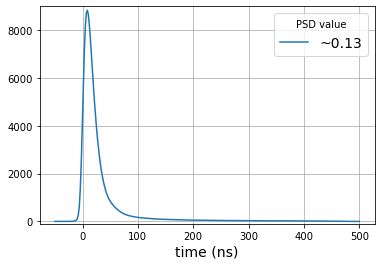

In [6]:
plt.plot(x,y, linestyle='-', marker='', label='~0.13')
#plt.plot(x1,y1, linestyle='-', marker='', label='~0.29', color='orange')
#plt.plot([x[0],x[-1]], [half_max,half_max], linestyle='-', marker='', color='r')
plt.grid()
plt.xlabel('time (ns)', fontsize=14)
plt.legend(title='PSD value', fontsize=14)
plt.ylim(-100,9000)
plt.rcParams["figure.figsize"] = (8,6)

In [6]:
def waveform_integral(xarray,yarray, intmin, intmax): 
    
    xarraycut = np.asarray([xarray[i] for i in range(len(xarray)) if intmin<xarray[i]<intmax])
    yarraycut = np.asarray([yarray[i] for i in range(len(xarray)) if intmin<xarray[i]<intmax])
    
    ymin_extra = np.interp(intmin, xarray, yarray)
    ymax_extra = np.interp(intmax, xarray, yarray)
    
    xarraycut = np.concatenate([[intmin],xarraycut,[intmax]])
    yarraycut = np.concatenate([[ymin_extra],yarraycut,[ymax_extra]])
    
    return np.trapz(yarraycut, x=xarraycut)

def get_time(xarray, yarray):
    
    half_max = np.amax(yarray)/2
    
    xarraycut = np.asarray([xarray[i] for i in range(len(xarray)) if -20<xarray[i]<20])
    yarraycut = np.asarray([yarray[i] for i in range(len(xarray)) if -20<xarray[i]<20])
    
    return np.interp(half_max, yarraycut, xarraycut, left=float('NaN'), right=float('NaN')) 

def get_total_area(xarray,yarray): 
    
    minx = np.amin(xarray)
    maxx = np.amax(xarray)
    
    return waveform_integral(xarray,yarray, intmin=minx, intmax=maxx) 

def get_PSD(xarray, yarray): 
    
    time = get_time(xarray, yarray)
    
    total = waveform_integral(xarray,yarray, intmin=-12+time, intmax=200+time)
    tail  =  waveform_integral(xarray,yarray, intmin=44+time, intmax=200+time)
    
    return tail/total
    
    

In [7]:
def scaling_scan(hmin, hmax, xarray, yarray, clipping_height):
    
    df = pd.DataFrame(columns=['dh', \
                               'scalefactor', \
                               'clipping_height', \
                               'ymax_unclipped', \
                               'ymax_clipped', \
                               'PSD_unclipped', \
                               'PSD_clipped', \
                               'totalarea_unclipped', \
                               'totalarea_clipped', \
                               'time_offset'])
    
    ymax = np.amax(yarray)
    #dh_array = np.arange(hmin, hmax, 300) - ymax
    dh_array = np.linspace(hmin, hmax, 500) - ymax
    
    for dh in dh_array: 
        
        scalefactor = (ymax + dh)/ymax
        
        yscaled = yarray*scalefactor
        yscaled_clipped = np.copy(yscaled)
        
        yscaled_clipped[yscaled_clipped > clipping_height] = clipping_height
        
        dh = dh
        scalefactor = scalefactor
        clipping_height = clipping_height
        ymax_unclipped = np.amax(yscaled)
        ymax_clipped = np.amax(yscaled_clipped)
        PSD_unclipped = get_PSD(xarray, yscaled)
        PSD_clipped = get_PSD(xarray, yscaled_clipped)
        totalarea_unclipped = get_total_area(xarray, yscaled)
        totalarea_clipped = get_total_area(xarray, yscaled_clipped) 
        time_offset = get_time(xarray, yscaled_clipped) - get_time(xarray, yscaled)
        
        df.loc[len(df)] = [dh, \
                           scalefactor, \
                           clipping_height, \
                           ymax_unclipped, \
                           ymax_clipped, \
                           PSD_unclipped, \
                           PSD_clipped, \
                           totalarea_unclipped, \
                           totalarea_clipped, \
                           time_offset]
        
    return df
    

### Combining Pulses

In [8]:
global_clipping = 60000

In [9]:
def combined_pulse_scan(TGraph, clipping_height, scale_ratio): 
    
    x,y = get_xy_from_TGraph(TGraph)
    y = y / (1+scale_ratio)
    df_early1 = scaling_scan(hmin=0.01, hmax=np.amax(y)*200, xarray=x, yarray=y, clipping_height=clipping_height)
    
    x,y = get_xy_from_TGraph(TGraph)
    y = y*scale_ratio / (1+scale_ratio)
    df_late1 = scaling_scan(hmin=0.01, hmax=np.amax(y)*200, xarray=x, yarray=y, clipping_height=clipping_height)
    

    df_late1 = df_late1.iloc[1:]
    df_early1 = df_early1.iloc[1:]
    
    combinedarea1 = np.asarray(df_early1['totalarea_clipped']) + np.asarray(df_late1['totalarea_clipped'])

    scaledPSD_early1 = np.asarray(df_early1['PSD_clipped'])*np.asarray(df_early1['totalarea_clipped'])/combinedarea1
    scaledPSD_late1 = np.asarray(df_late1['PSD_clipped'])*np.asarray(df_late1['totalarea_clipped'])/combinedarea1

    combinedPSD1 = scaledPSD_early1 + scaledPSD_late1
    
    return combinedarea1, combinedPSD1

In [10]:
combinedarea1, combinedPSD1 = combined_pulse_scan(graph_early, global_clipping, 0.1)
print('Working...')
combinedarea2, combinedPSD2 = combined_pulse_scan(graph_early, global_clipping, 0.2)
print('Working...')
combinedarea3, combinedPSD3 = combined_pulse_scan(graph_early, global_clipping, 0.3)
print('Working...')
combinedarea4, combinedPSD4 = combined_pulse_scan(graph_early, global_clipping, 0.4)
print('Working...')
combinedarea5, combinedPSD5 = combined_pulse_scan(graph_early, global_clipping, 0.5)
print('Working...')
combinedarea6, combinedPSD6 = combined_pulse_scan(graph_early, global_clipping, 0.6)
print('Working...')
combinedarea7, combinedPSD7 = combined_pulse_scan(graph_early, global_clipping, 0.7)
print('Working...')
combinedarea8, combinedPSD8 = combined_pulse_scan(graph_early, global_clipping, 0.8)
print('Working...')
combinedarea9, combinedPSD9 = combined_pulse_scan(graph_early, global_clipping, 0.9)
print('Working...')
combinedarea10, combinedPSD10 = combined_pulse_scan(graph_early, global_clipping, 1.0)
print('Working...')

Working...
Working...
Working...
Working...
Working...
Working...
Working...
Working...
Working...
Working...


### Plot

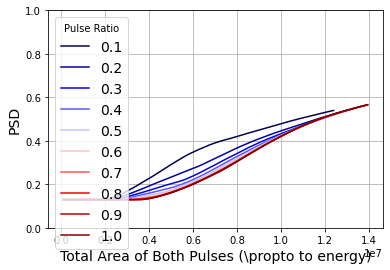

In [11]:
colormap = plt.cm.gist_ncar
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.seismic(np.linspace(0, 1, 10))))

plt.rcParams["figure.figsize"] = (8,6)

plt.plot(combinedarea1, combinedPSD1, marker='', linestyle='-', label='0.1') 
plt.plot(combinedarea2, combinedPSD2, marker='', linestyle='-', label='0.2') 
plt.plot(combinedarea3, combinedPSD3, marker='', linestyle='-', label='0.3') 
plt.plot(combinedarea4, combinedPSD4, marker='', linestyle='-', label='0.4') 
plt.plot(combinedarea5, combinedPSD5, marker='', linestyle='-', label='0.5') 
plt.plot(combinedarea6, combinedPSD6, marker='', linestyle='-', label='0.6') 
plt.plot(combinedarea7, combinedPSD7, marker='', linestyle='-', label='0.7') 
plt.plot(combinedarea8, combinedPSD8, marker='', linestyle='-', label='0.8') 
plt.plot(combinedarea9, combinedPSD9, marker='', linestyle='-', label='0.9') 
plt.plot(combinedarea10, combinedPSD10, marker='', linestyle='-', label='1.0') 


plt.grid()
plt.ylim(0,1)
plt.xlabel('Total Area of Both Pulses (\propto to energy)', fontsize=14)
plt.ylabel('PSD', fontsize=14)
plt.title('')
plt.legend(title='Pulse Ratio',fontsize=14)


Text(0.5, 1.0, 'Pulse ratio 0.8')

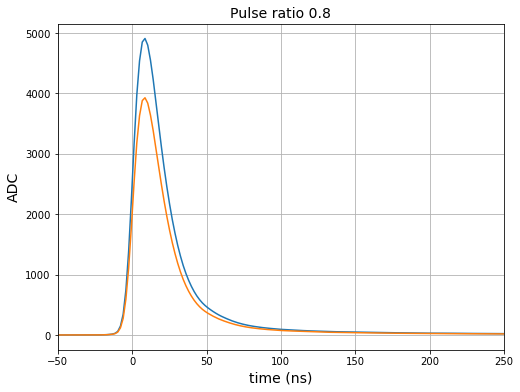

In [14]:
#example plots to define "scale ratio" 

scale_ratio = 0.8

x1,y1 = get_xy_from_TGraph(graph_early)
y1 = y1 / (1+scale_ratio)

x2,y2 = get_xy_from_TGraph(graph_early)
y2 = y2*scale_ratio / (1+scale_ratio)

plt.plot(x1, y1)
plt.plot(x2, y2)
plt.xlabel('time (ns)', fontsize=14)
plt.xlim(-50, 250)
plt.ylabel('ADC', fontsize=14)
plt.grid()
plt.title('Pulse ratio '+str(scale_ratio), fontsize=14)

In [35]:
# plot on top of TH2 from simulation

xscale = 0.000009
yscale = 1.1

PSDvE_graph1 = ROOT.TGraph(len(combinedarea1), combinedarea1*xscale, combinedPSD1*yscale)
PSDvE_graph2 = ROOT.TGraph(len(combinedarea1), combinedarea2*xscale, combinedPSD2*yscale)
PSDvE_graph3 = ROOT.TGraph(len(combinedarea1), combinedarea3*xscale, combinedPSD3*yscale)
PSDvE_graph4 = ROOT.TGraph(len(combinedarea1), combinedarea4*xscale, combinedPSD4*yscale)
PSDvE_graph5 = ROOT.TGraph(len(combinedarea1), combinedarea5*xscale, combinedPSD5*yscale)
PSDvE_graph6 = ROOT.TGraph(len(combinedarea1), combinedarea6*xscale, combinedPSD6*yscale)
PSDvE_graph7 = ROOT.TGraph(len(combinedarea1), combinedarea7*xscale, combinedPSD7*yscale)
PSDvE_graph8 = ROOT.TGraph(len(combinedarea1), combinedarea8*xscale, combinedPSD8*yscale)
PSDvE_graph9 = ROOT.TGraph(len(combinedarea1), combinedarea9*xscale, combinedPSD9*yscale)
PSDvE_graph10 = ROOT.TGraph(len(combinedarea1), combinedarea10*xscale, combinedPSD10*yscale)


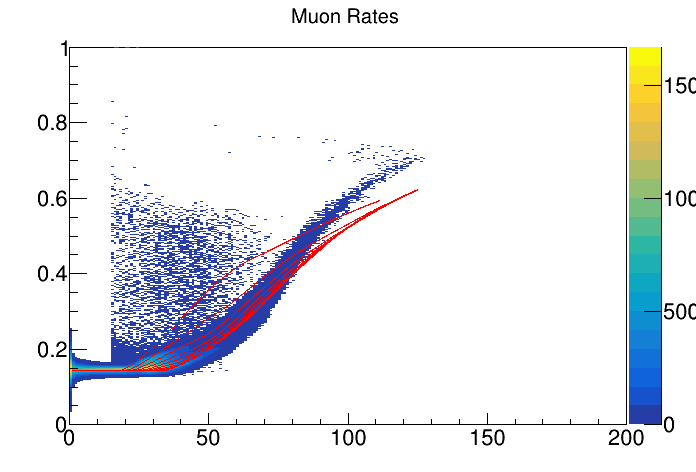

In [36]:
c1 = ROOT.TCanvas()
PSDvE.Draw('colz')

PSDvE_graph1.SetLineColor(2);
PSDvE_graph1.Draw('L')
PSDvE_graph2.SetLineColor(2);
PSDvE_graph2.Draw('L')
PSDvE_graph3.SetLineColor(2);
PSDvE_graph3.Draw('L')
PSDvE_graph4.SetLineColor(2);
PSDvE_graph4.Draw('L')
PSDvE_graph5.SetLineColor(2);
PSDvE_graph5.Draw('L')
PSDvE_graph6.SetLineColor(2);
PSDvE_graph6.Draw('L')
PSDvE_graph7.SetLineColor(2);
PSDvE_graph7.Draw('L')
PSDvE_graph8.SetLineColor(2);
PSDvE_graph8.Draw('L')
PSDvE_graph9.SetLineColor(2);
PSDvE_graph9.Draw('L')
PSDvE_graph10.SetLineColor(2);
PSDvE_graph10.Draw('L')


c1.Draw()

In [ ]:
file = uproot.open('AD1_Wet_MuonTracking.root')
PSDvE_np = file["MuonTracking/hPSDvE"].to_hist()

### Compare with series 11 data

In [4]:
f = h5py.File('raw/s011_f00001_ts1520181395.h5', 'r')

# get the dataset from the h5 file
waveforms = f['Waveforms']
chanmap = f['Chanmap']
# take the first 1M pulses, for playing around we don't need too many
waveforms = waveforms[0:5000000]

l = list(waveforms)

for i in range(len(l)): 
    if i%1000000 == 0: 
        print("On line: "+str(i))
    l[i] = list(l[i])
    
df = pd.DataFrame(l, columns=['event_number','det_number','arrival_time','area','psd','pulse','pid','simtruth_E','simtruth_Z'])
total_det = 2*11*14 - 1

df = df[df.det_number <= total_det]
df = df[df.det_number >= 0]
df = df[df.psd > 0]
df = df[df.psd < 1]

df_largearea = df[df.area > 1000]

areas = np.asarray(df_largearea['area'])
psds = np.asarray(df_largearea['psd'])
print(len(areas))

if 'h2' in vars(): 
    del h2

h2 = ROOT.TH2F('h2', 'PSD vs area', 100, 0, 500000, 100, 0, 1)
for i in range(len(areas)): 
    h2.Fill(areas[i], psds[i])

On line: 0
On line: 1000000
On line: 2000000
On line: 3000000
On line: 4000000
1928


In [43]:
xscale = 0.028
yscale = 1.0

PSDvE_graph1 = ROOT.TGraph(len(combinedarea1), combinedarea1*xscale, combinedPSD1*yscale)
PSDvE_graph2 = ROOT.TGraph(len(combinedarea1), combinedarea2*xscale, combinedPSD2*yscale)
PSDvE_graph3 = ROOT.TGraph(len(combinedarea1), combinedarea3*xscale, combinedPSD3*yscale)
PSDvE_graph4 = ROOT.TGraph(len(combinedarea1), combinedarea4*xscale, combinedPSD4*yscale)
PSDvE_graph5 = ROOT.TGraph(len(combinedarea1), combinedarea5*xscale, combinedPSD5*yscale)
PSDvE_graph6 = ROOT.TGraph(len(combinedarea1), combinedarea6*xscale, combinedPSD6*yscale)
PSDvE_graph7 = ROOT.TGraph(len(combinedarea1), combinedarea7*xscale, combinedPSD7*yscale)
PSDvE_graph8 = ROOT.TGraph(len(combinedarea1), combinedarea8*xscale, combinedPSD8*yscale)
PSDvE_graph9 = ROOT.TGraph(len(combinedarea1), combinedarea9*xscale, combinedPSD9*yscale)
PSDvE_graph10 = ROOT.TGraph(len(combinedarea1), combinedarea10*xscale, combinedPSD10*yscale)

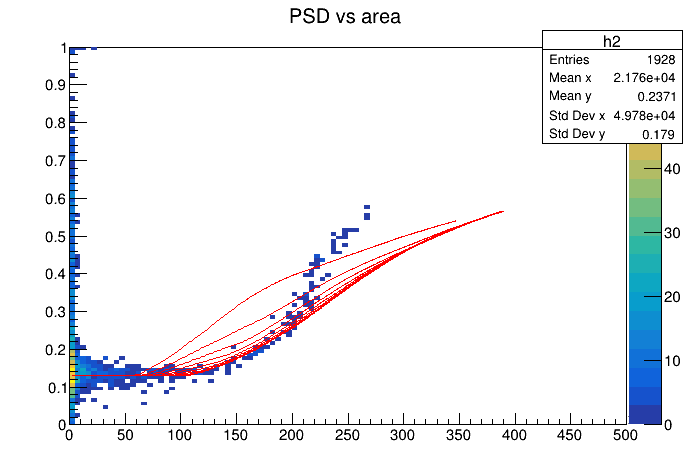

In [44]:
c5 = ROOT.TCanvas()
h2.Draw('colz')

PSDvE_graph1.SetLineColor(2);
PSDvE_graph1.Draw('L')
PSDvE_graph2.SetLineColor(2);
PSDvE_graph2.Draw('L')
PSDvE_graph3.SetLineColor(2);
PSDvE_graph3.Draw('L')
PSDvE_graph4.SetLineColor(2);
PSDvE_graph4.Draw('L')
PSDvE_graph5.SetLineColor(2);
PSDvE_graph5.Draw('L')
PSDvE_graph6.SetLineColor(2);
PSDvE_graph6.Draw('L')
PSDvE_graph7.SetLineColor(2);
PSDvE_graph7.Draw('L')
PSDvE_graph8.SetLineColor(2);
PSDvE_graph8.Draw('L')
PSDvE_graph9.SetLineColor(2);
PSDvE_graph9.Draw('L')
PSDvE_graph10.SetLineColor(2);
PSDvE_graph10.Draw('L')

c5.Draw()

In [1]:
df

NameError: name 'df' is not defined